# TASK 3: Contrastive Models – Analyzing CLIP (ViT-B/32) and Multimodal Biases #

<h2> Setting up the workspace <h2>

In [1]:
!pip install -q transformers datasets torch scikit-learn matplotlib Pillow


[notice] A new release of pip is available: 23.2.1 -> 25.2
[notice] To update, run: python.exe -m pip install --upgrade pip


In [2]:
import torch
from transformers import CLIPProcessor, CLIPModel
from PIL import Image
import numpy as np
import random
import torchvision
import torchvision.transforms as transforms
from torchvision.models import resnet50, ResNet50_Weights
from torch.utils.data import DataLoader
from tqdm import tqdm


In [3]:
# --- The "Seed Everything" Cell ---
SEED = 42 # You can pick any number, 42 is a popular choice

random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed_all(SEED) # if you are using GPU

print(f"Random seed set to {SEED}")

Random seed set to 42


In [4]:
# --- 1. Setup Device ---
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using device: {device}")

# --- 2. Load the Model and Processor ---
# using the 'openai/clip-vit-base-patch32' version of CLIP.
model_name = "openai/clip-vit-base-patch32"

# CLIPModel contains the image and text encoders.
model = CLIPModel.from_pretrained(model_name).to(device)

# CLIPProcessor handles the image preprocessing and text tokenization.
processor = CLIPProcessor.from_pretrained(model_name)

print("\nCLIP model and processor loaded successfully!")
print("Model is on device:", model.device)

Using device: cuda


Using a slow image processor as `use_fast` is unset and a slow processor was saved with this model. `use_fast=True` will be the default behavior in v4.52, even if the model was saved with a slow processor. This will result in minor differences in outputs. You'll still be able to use a slow processor with `use_fast=False`.



CLIP model and processor loaded successfully!
Model is on device: cuda:0


<h2> Part 1: Zero-Shot Classification <h2>

<h3> Supervised Model accuracy on CIFAR-10 dataset: <h3>

In [5]:
baseline_model_path = "C:/Users/Haseeb/OneDrive - Higher Education Commission/ATML (CS6304)/PA1/ATML_PA1/resnet50_cifar10.pth"

# We must specify the number of output classes to match CIFAR-10 (which is 10).
baseline_model = resnet50(num_classes=10)

try:
    # Load the state dictionary (the trained weights) from the file.
    # map_location=device ensures the model loads correctly whether you're on CPU or GPU.
    state_dict = torch.load(baseline_model_path, map_location=device)
    
    # Load the weights into the model architecture.
    baseline_model.load_state_dict(state_dict)
    
    # Move the model to the GPU if available.
    baseline_model.to(device)
    
    # Set the model to evaluation mode. This is CRITICAL.
    # It disables layers like Dropout and normalizes batch statistics correctly for inference.
    baseline_model.eval()
    
    print("Baseline ResNet-50 model loaded successfully.")

except FileNotFoundError:
    print(f"ERROR: Model file not found at '{baseline_model_path}'. Please update the path.")
    baseline_model = None
except Exception as e:
    print(f"An error occurred while loading the model: {e}")
    baseline_model = None


if baseline_model:
    # The normalization values are standard for models pre-trained on ImageNet.
    transform_resnet = transforms.Compose([
        transforms.Resize((224, 224)), # Resize CIFAR images to what ResNet expects
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    ])

    # Download and load the CIFAR-10 test dataset
    testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                           download=True, transform=transform_resnet)
    
    # Create a DataLoader to efficiently feed data to the model in batches.
    testloader = DataLoader(testset, batch_size=64, shuffle=False, num_workers=2)
    
    print("\nCIFAR-10 test data prepared for ResNet evaluation.")

# ==============================================================================
# 4. RUN THE EVALUATION
# ==============================================================================

if baseline_model:
    correct = 0
    total = 0
    
    # We don't need to track gradients during evaluation, which saves memory and speeds things up.
    with torch.no_grad():
        for data in tqdm(testloader, desc="Evaluating ResNet on CIFAR-10"):
            images, labels = data
            # Move data to the same device as the model
            images, labels = images.to(device), labels.to(device)
            
            # Forward pass: get predictions from the model
            outputs = baseline_model(images)
            
            # The prediction is the class with the highest score
            _, predicted = torch.max(outputs.data, 1)
            
            # Update totals
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    accuracy = 100 * correct / total
    print(f"\n--- Verification Complete ---")
    print(f"Accuracy of the baseline model on the 10,000 CIFAR-10 test images: {accuracy:.2f}%")

    if accuracy >= 90:
        print("This is a strong result. The model appears to be correctly trained.")

Baseline ResNet-50 model loaded successfully.

CIFAR-10 test data prepared for ResNet evaluation.


Evaluating ResNet on CIFAR-10: 100%|██████████| 157/157 [00:10<00:00, 14.30it/s]


--- Verification Complete ---
Accuracy of the baseline model on the 10,000 CIFAR-10 test images: 96.11%
This is a strong result. The model appears to be correctly trained.


<h3> CLIP accuracy on the CIFAR-10 dataset <h3>

CIFAR-10 test set loaded.

Example image loaded. It's a 'cat' (Label ID: 3).


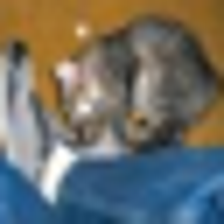

In [6]:
from datasets import load_dataset
import random

# Load the CIFAR-10 dataset
# We only need the 'test' split for evaluation.
# 'streaming=True' is memory-efficient as it doesn't download the whole dataset at once.
cifar10_dataset = load_dataset("cifar10", split="test", streaming=True)

print("CIFAR-10 test set loaded.")

# Let's inspect one example to see what the data looks like
example = next(iter(cifar10_dataset))
image = example['img']
true_label_id = example['label']

# The dataset has class names we can use.
class_names = cifar10_dataset.features['label'].names
true_label_name = class_names[true_label_id]

print(f"\nExample image loaded. It's a '{true_label_name}' (Label ID: {true_label_id}).")
display(image.resize((224, 224))) # Display the image (resized for better viewing)

In [13]:
# Get the list of class names from the dataset
class_names = cifar10_dataset.features['label'].names
print("Class names:", class_names)

# Create the text prompts using a template.
# This format helps CLIP understand that we are looking for objects in photos.
text_prompts = [f"a photo of a {name}" for name in class_names]
print("\nGenerated text prompts:")
for prompt in text_prompts:
    print(prompt)

Class names: ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']

Generated text prompts:
a photo of a airplane
a photo of a automobile
a photo of a bird
a photo of a cat
a photo of a deer
a photo of a dog
a photo of a frog
a photo of a horse
a photo of a ship
a photo of a truck


<h3> Testing on 1 image for now <h3>

In [14]:
from tqdm import tqdm # A library to show a progress bar, very useful!
import numpy as np

# --- 1. Prepare Inputs for the Model ---
# We need to process the image and all text prompts.
# The `processor` handles everything: resizing/normalizing the image, and tokenizing the text.
# The `padding=True` and `return_tensors="pt"` parts ensure all text prompts are the same length
# and are returned as PyTorch tensors.
inputs = processor(text=text_prompts, images=image, return_tensors="pt", padding=True)

# --- 2. Move Inputs to the GPU ---
# Important: The data must be on the same device as the model.
inputs = {k: v.to(device) for k, v in inputs.items()}

# --- 3. Get Embeddings from CLIP ---
# We run the model. `torch.no_grad()` tells PyTorch not to calculate gradients,
# which saves memory and computation since we are not training.
with torch.no_grad():
    outputs = model(**inputs)

# The model outputs embeddings for both the image and the text.
image_embedding = outputs.image_embeds
text_embeddings = outputs.text_embeds

# --- 4. Calculate Similarity ---
# We calculate the cosine similarity between the single image embedding and all 10 text embeddings.
# The model's output is already normalized, so we can use a simple matrix multiplication.
# logits_per_image has shape (1, 10), representing the similarity scores for our image against each text prompt.
logits_per_image = image_embedding @ text_embeddings.T

# --- 5. Get the Prediction ---
# We find the class with the highest score.
# `probs` will contain the probabilities (after applying softmax).
# `argmax(dim=1)` finds the index of the highest value along the row.
probs = logits_per_image.softmax(dim=1)
predicted_label_id = probs.argmax(dim=1).item()
predicted_label_name = class_names[predicted_label_id]

print(f"True Label: {true_label_name}")
print(f"Predicted Label: {predicted_label_name}")

# Let's print the probabilities for each class to see the model's "thinking"
print("\nSimilarity Scores (Probabilities):")
for i, name in enumerate(class_names):
    print(f"- {name:<12}: {probs[0, i].item():.4f}")

True Label: cat
Predicted Label: cat

Similarity Scores (Probabilities):
- airplane    : 0.0989
- automobile  : 0.0997
- bird        : 0.1006
- cat         : 0.1020
- deer        : 0.0994
- dog         : 0.1014
- frog        : 0.0997
- horse       : 0.0996
- ship        : 0.1006
- truck       : 0.0981


<h3> Testing on whole CIFAR-10 dataset now <h3>

In [15]:
num_correct = 0
num_total = 0

# testing on whole dataset
num_test_samples = 10000 

# Re-initialize the dataset stream
cifar10_test_stream = load_dataset("cifar10", split="test", streaming=True)

# Pre-compute text features once to save time
with torch.no_grad():
    text_inputs = processor(text=text_prompts, return_tensors="pt", padding=True)
    text_inputs = {k: v.to(device) for k, v in text_inputs.items()}
    text_features = model.get_text_features(**text_inputs)

# The main evaluation loop
for example in tqdm(cifar10_test_stream.take(num_test_samples), total=num_test_samples):
    image = example['img']
    true_label = example['label']
    
    # Process the image
    image_input = processor(images=image, return_tensors="pt").to(device)
    
    with torch.no_grad():
        # Get image features
        image_features = model.get_image_features(**image_input)
        
        # Calculate similarity
        logits = image_features @ text_features.T
        
        # Get prediction
        prediction = logits.argmax(dim=-1).item()
        
    if prediction == true_label:
        num_correct += 1
    num_total += 1

accuracy = (num_correct / num_total) * 100
print(f"\nFinished evaluating on {num_total} samples.")
print(f"Zero-shot accuracy on CIFAR-10: {accuracy:.2f}%")

100%|██████████| 10000/10000 [01:38<00:00, 101.99it/s]


Finished evaluating on 10000 samples.
Zero-shot accuracy on CIFAR-10: 79.98%


<h3> Testing Generalization to New Domains <h3>

<h3> CLIP accuracy on the PACS sketch domain: <h3>

Found 3929 images in 7 classes.
Classes found: ['dog', 'elephant', 'giraffe', 'guitar', 'horse', 'house', 'person']
Class to index mapping: {'dog': 0, 'elephant': 1, 'giraffe': 2, 'guitar': 3, 'horse': 4, 'house': 5, 'person': 6}

Example sketch image loaded. It's a 'guitar' (Label ID: 3).


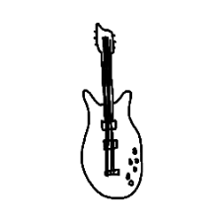

In [16]:
import os
from torch.utils.data import Dataset, DataLoader
from torchvision.datasets import ImageFolder
from PIL import Image

# --- 1. Define the path to your local sketch data ---
data_path = r"D:\Haseeb\SPROJ\PACS ViT\pacs_data\pacs_data\sketch"

# --- 2. Use torchvision's ImageFolder to load the data ---
# ImageFolder automatically finds the classes (subfolder names) and images.
sketch_dataset_local = ImageFolder(root=data_path)

# --- 3. Extract class names and map them ---
# ImageFolder assigns an integer ID to each class name.
pacs_class_names = sketch_dataset_local.classes
class_to_idx = sketch_dataset_local.class_to_idx
idx_to_class = {v: k for k, v in class_to_idx.items()}

print(f"Found {len(sketch_dataset_local)} images in {len(pacs_class_names)} classes.")
print("Classes found:", pacs_class_names)
print("Class to index mapping:", class_to_idx)


# --- 4. Inspect an example ---
# Let's grab a random sample to check.
import random
random_index = random.randint(0, len(sketch_dataset_local) - 1)
sketch_image, sketch_label_id = sketch_dataset_local[random_index]
sketch_label_name = idx_to_class[sketch_label_id]

print(f"\nExample sketch image loaded. It's a '{sketch_label_name}' (Label ID: {sketch_label_id}).")
display(sketch_image.resize((224, 224)))

In [17]:
pacs_class_names = sketch_dataset_local.classes

sketch_text_prompts = [f"a sketch of a {name}" for name in pacs_class_names]

print("Generated text prompts for the sketch domain:")
for prompt in sketch_text_prompts:
    print(prompt)


# sketch_text_prompts_v2 = [f"a drawing of a {name}" for name in pacs_class_names]

Generated text prompts for the sketch domain:
a sketch of a dog
a sketch of a elephant
a sketch of a giraffe
a sketch of a guitar
a sketch of a horse
a sketch of a house
a sketch of a person


In [18]:
def evaluate_pil_dataset_one_by_one(model, processor, dataset, text_prompts, device):
    """
    Evaluates a dataset yielding PIL images one by one.
    This is slower but ensures correct processing for each image.
    """
    num_correct = 0
    num_samples = len(dataset)
    
    # Pre-compute text features
    with torch.no_grad():
        text_inputs = processor(text=text_prompts, return_tensors="pt", padding=True).to(device)
        text_features = model.get_text_features(**text_inputs)
        text_features /= text_features.norm(dim=-1, keepdim=True)

    # Loop through the dataset one image at a time
    for i in tqdm(range(num_samples), desc="Evaluating PIL Images"):
        image, true_label = dataset[i] # Get PIL Image and label
        
        # The CLIP processor expects a list of images, so we wrap it
        inputs = processor(images=[image], return_tensors="pt").to(device)
        
        with torch.no_grad():
            image_features = model.get_image_features(**inputs)
            image_features /= image_features.norm(dim=-1, keepdim=True)
            
            similarity = (100.0 * image_features @ text_features.T).softmax(dim=-1)
            prediction = similarity.argmax(dim=-1).item()
            
        if prediction == true_label:
            num_correct += 1
            
    accuracy = (num_correct / num_samples) * 100
    return accuracy



In [19]:
from tqdm import tqdm
import torch

# --- Run the corrected evaluation ---
sketch_accuracy = evaluate_pil_dataset_one_by_one(
    model=model,
    processor=processor,
    dataset=sketch_dataset_local,
    text_prompts=sketch_text_prompts, # Make sure this is defined from before
    device=device
)

print(f"\nFinished evaluating on {len(sketch_dataset_local)} local sketch samples.")
print(f"Zero-shot accuracy on PACS (Sketch domain): {sketch_accuracy:.2f}%")

Evaluating PIL Images: 100%|██████████| 3929/3929 [00:48<00:00, 81.35it/s] 


Finished evaluating on 3929 local sketch samples.
Zero-shot accuracy on PACS (Sketch domain): 85.06%


<h2> Part 2: Image-Text Retrieval <h2>

Added 16 images from local PACS dataset.
Added 4 images from CIFAR-10.
Added images from the web. Total gallery size: 20.

--- Final Assembled Image Gallery ---


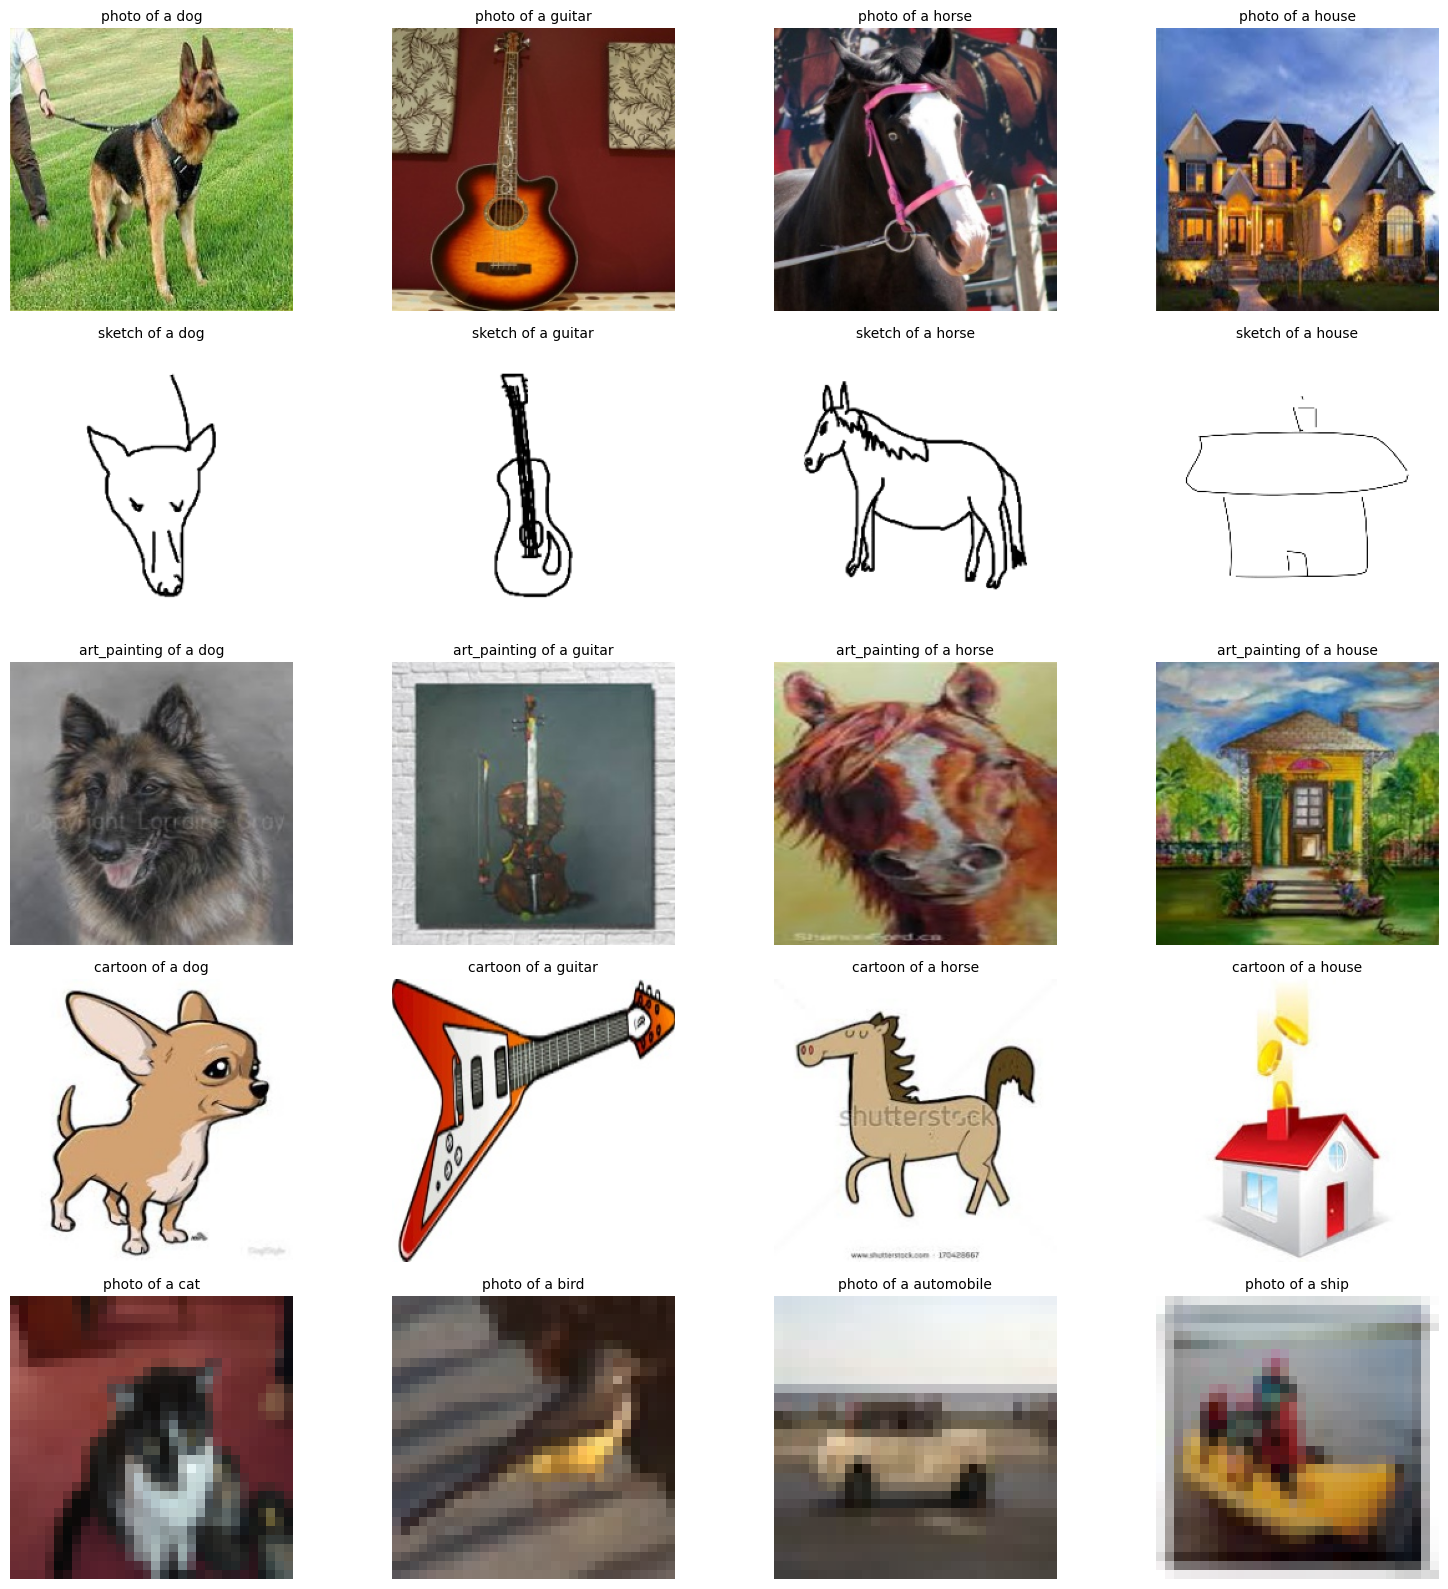

In [21]:
from PIL import Image
import requests
import torch
import random
from datasets import load_dataset
from torchvision.datasets import ImageFolder
import matplotlib.pyplot as plt

# --- 1. Setup ---
gallery_images = []
gallery_labels = [] # We'll use this for our own reference and plotting
num_images_to_select = 20

# Helper function to avoid adding duplicate classes
def add_to_gallery(image, label):
    if len(gallery_images) < num_images_to_select:
        gallery_images.append(image.convert("RGB"))
        gallery_labels.append(label)
        return True
    return False

# --- 2. Load from Local PACS Dataset (Photos, Sketches, Art, Cartoons) ---
pacs_base_path = r"D:\Haseeb\SPROJ\PACS ViT\pacs_data\pacs_data"
domains = ['photo', 'sketch', 'art_painting', 'cartoon']
pacs_classes_to_get = ['dog', 'guitar', 'horse', 'house'] # Let's pick a few classes

for domain in domains:
    for pacs_class in pacs_classes_to_get:
        # Construct the path to a specific class within a domain
        class_path = os.path.join(pacs_base_path, domain, pacs_class)
        if os.path.exists(class_path):
            # Get a random image from that folder
            random_image_file = random.choice(os.listdir(class_path))
            image_path = os.path.join(class_path, random_image_file)
            image = Image.open(image_path)
            
            label = f"{domain} of a {pacs_class}"
            add_to_gallery(image, label)

print(f"Added {len(gallery_images)} images from local PACS dataset.")

# --- 3. Load from CIFAR-10 (Low-resolution photos) ---
cifar10_stream = load_dataset("cifar10", split="test", streaming=True).shuffle(seed=42)
cifar10_classes = cifar10_stream.features['label'].names
cifar_classes_to_get = ['automobile', 'bird', 'cat', 'ship']
added_cifar_classes = set()

for example in cifar10_stream:
    label_name = cifar10_classes[example['label']]
    if label_name in cifar_classes_to_get and label_name not in added_cifar_classes:
        label = f"photo of a {label_name}"
        if add_to_gallery(example['img'], label):
            added_cifar_classes.add(label_name)
        else:
            break # Stop if gallery is full

print(f"Added {len(added_cifar_classes)} images from CIFAR-10.")

# --- 4. Add Curated Images from the Web (If gallery is not yet full) ---
web_images_to_add = [
    {"url": "https://images.unsplash.com/photo-1579252724953-c78b4d13e659?q=80&w=2520", "label": "astronaut on a horse"},
    {"url": "https://images.unsplash.com/photo-1583337130417-3346a1be7dee?q=80&w=2264", "label": "dog wearing sunglasses"},
    # Add more URLs and labels here if needed
]

for item in web_images_to_add:
    if len(gallery_images) < num_images_to_select:
        try:
            web_image = Image.open(requests.get(item["url"], stream=True).raw)
            add_to_gallery(web_image, item["label"])
        except Exception as e:
            print(f"Could not download {item['label']}: {e}")
    else:
        break

print(f"Added images from the web. Total gallery size: {len(gallery_images)}.")

# --- 5. Display the Final Gallery ---
print("\n--- Final Assembled Image Gallery ---")
fig, axes = plt.subplots((len(gallery_images) + 3) // 4, 4, figsize=(16, 16))
axes = axes.flatten()
for i, (img, label) in enumerate(zip(gallery_images, gallery_labels)):
    axes[i].imshow(img)
    axes[i].set_title(label, fontsize=10)
    axes[i].axis('off')

# Hide any unused subplots
for j in range(i + 1, len(axes)):
    axes[j].axis('off')

plt.tight_layout()
plt.show()

In [22]:
text_queries = [
    "a sketch of a dog's head",
    "a painting of a fluffy dog",
    "a cartoon chihuahua",
    "a photo of a horse with a pink bridle",
    "an acoustic guitar against a red wall",
    "a drawing of a simple house",
    "a red and white electric guitar",
    "a blurry photo of a black and white cat"
]

print("Updated text queries for retrieval:")
for query in text_queries:
    print(f"- {query}")

Updated text queries for retrieval:
- a sketch of a dog's head
- a painting of a fluffy dog
- a cartoon chihuahua
- a photo of a horse with a pink bridle
- an acoustic guitar against a red wall
- a drawing of a simple house
- a red and white electric guitar
- a blurry photo of a black and white cat



Computing embeddings for all 20 gallery images...
Image embeddings computed.
Performing retrieval for each text query...


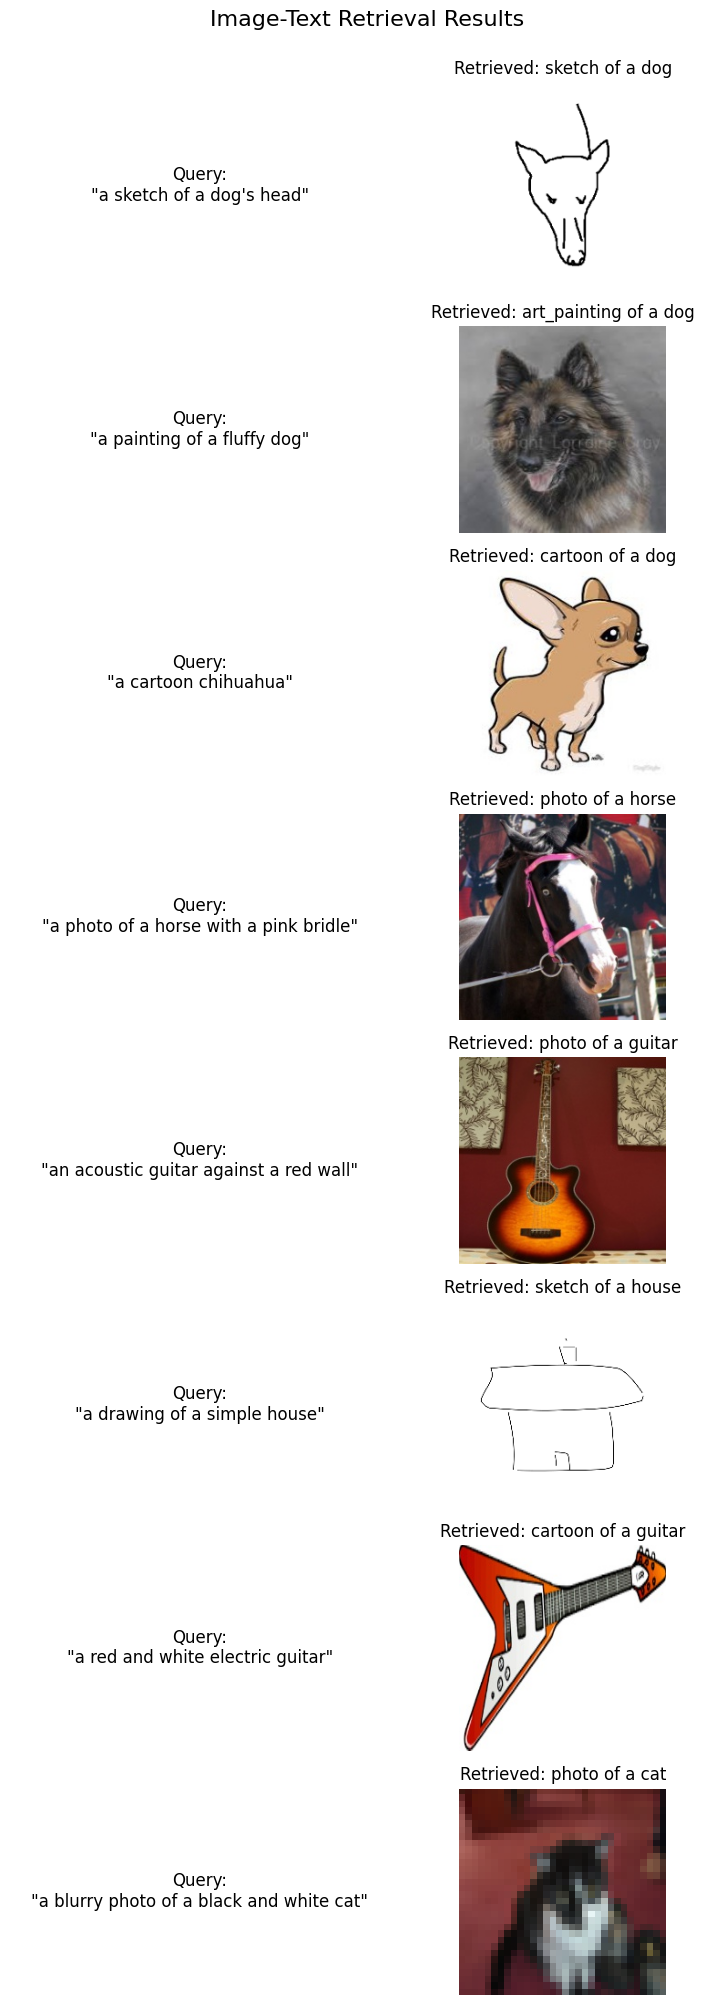


Retrieval task complete.


In [23]:
import torch
import matplotlib.pyplot as plt

# --- 1. Compute embeddings for all gallery images ---
print("\nComputing embeddings for all 20 gallery images...")
with torch.no_grad():
    # Process all images at once in a batch
    image_inputs = processor(images=gallery_images, return_tensors="pt", padding=True).to(device)
    gallery_image_features = model.get_image_features(**image_inputs)
    # Normalize the features for cosine similarity
    gallery_image_features /= gallery_image_features.norm(dim=-1, keepdim=True)
print("Image embeddings computed.")

# --- 2. Loop through each text query and find the best image match ---
# Create the plot figure
fig, axes = plt.subplots(len(text_queries), 2, figsize=(8, 20))
fig.suptitle("Image-Text Retrieval Results", fontsize=16, y=1.0)

print("Performing retrieval for each text query...")
for i, query in enumerate(text_queries):
    with torch.no_grad():
        # Compute the text embedding for the current query
        text_inputs = processor(text=[query], return_tensors="pt", padding=True).to(device)
        text_features = model.get_text_features(**text_inputs)
        text_features /= text_features.norm(dim=-1, keepdim=True)
        
        # --- 3. Calculate Cosine Similarities ---
        similarities = (text_features @ gallery_image_features.T).squeeze()
        
        # --- 4. Find the best match ---
        best_match_idx = similarities.argmax().item()
        best_matching_image = gallery_images[best_match_idx]
        
        # --- 5. Visualize the result ---
        # Left column: Text Query
        axes[i, 0].text(0.5, 0.5, f'Query:\n"{query}"', ha='center', va='center', fontsize=12, wrap=True)
        axes[i, 0].axis('off')
        
        # Right column: Retrieved Image
        axes[i, 1].imshow(best_matching_image)
        axes[i, 1].set_title(f"Retrieved: {gallery_labels[best_match_idx]}") # Optional: show the original label
        axes[i, 1].axis('off')

plt.tight_layout()
plt.show()
print("\nRetrieval task complete.")

<h2> Part 3: Representation Analysis <h2>

<h3> CLIP: <h3>

Assembling visualization dataset...
Using base path: D:\Haseeb\SPROJ\PACS ViT\pacs_data\pacs_data


Dataset assembled successfully with 28 images.

Example from the dataset:


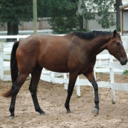

Class: horse, Domain: photo


In [21]:
import os
from PIL import Image
import random

# --- 1. Setup ---
viz_images = []
viz_labels_class = [] # e.g., 'dog', 'horse'
viz_labels_domain = [] # e.g., 'photo', 'sketch'

# --- 2. Select data from your local PACS dataset ---
try:
    drive_letter = "D:"
    path_components = ["Haseeb", "SPROJ", "PACS ViT", "pacs_data", "pacs_data"]
    pacs_base_path = os.path.join(drive_letter + os.sep, *path_components)
except NameError:
    # Fallback for non-Windows environments if needed, though not your case
    pacs_base_path = os.path.join("D:", "Haseeb", "SPROJ", "PACS ViT", "pacs_data", "pacs_data")


# The classes and domains to look for in the subfolders
classes_to_viz = ['dog', 'horse', 'guitar', 'house', 'elephant', 'giraffe', 'person'] 
domains_to_viz = ['photo', 'sketch', 'art_painting', 'cartoon']

print("Assembling visualization dataset...")
print(f"Using base path: {pacs_base_path}\n")

# --- Loop to find and load images ---
for class_name in classes_to_viz:
    for domain_name in domains_to_viz:
        class_path = os.path.join(pacs_base_path, domain_name, class_name)
        
        if os.path.exists(class_path) and len(os.listdir(class_path)) > 0:
            # print("Found!") # Optional: uncomment for verbose debugging
            # Get one random image from the folder
            random_image_file = random.choice(os.listdir(class_path))
            image_path = os.path.join(class_path, random_image_file)
            image = Image.open(image_path).convert("RGB")
            
            viz_images.append(image)
            viz_labels_class.append(class_name)
            viz_labels_domain.append(domain_name)
        else:
            # This path was not found or the folder was empty.
            # print("Not found or empty.") # Optional: uncomment for verbose debugging
            pass # Silently continue if a specific class/domain combo doesn't exist



print(f"\nDataset assembled successfully with {len(viz_images)} images.")
# Example: 7 classes * 4 domains = 28 images.

# Let's check a few examples
print("\nExample from the dataset:")
random_idx = random.randint(0, len(viz_images) - 1)

# Display the image
display(viz_images[random_idx].resize((128, 128)))

# Print its labels
print(f"Class: {viz_labels_class[random_idx]}, Domain: {viz_labels_domain[random_idx]}")

In [22]:
import torch
import numpy as np

# This function will take a list of images and a model and return embeddings
def get_embeddings(image_list, model, processor, device):
    # For now, this is just for CLIP. We'll adapt it later for the baseline.
    if model is None:
        return None
    
    with torch.no_grad():
        inputs = processor(images=image_list, return_tensors="pt", padding=True).to(device)
        image_features = model.get_image_features(**inputs)
        # Move embeddings to CPU and convert to numpy for t-SNE
        return image_features.cpu().numpy()

# --- Extract embeddings for our visualization images using CLIP ---
clip_embeddings = get_embeddings(viz_images, model, processor, device)

print(f"Extracted CLIP embeddings. Shape: {clip_embeddings.shape}")
# The shape should be (num_images, embedding_dim), e.g., (28, 512)

Extracted CLIP embeddings. Shape: (28, 512)


t-SNE computation complete. Result shape: (28, 2)

--- Plotting Legend ---
Class -> Color: dict_keys(['dog', 'elephant', 'giraffe', 'guitar', 'horse', 'house', 'person'])
Domain -> Marker: {'art_painting': 'o', 'cartoon': 'X', 'photo': 's', 'sketch': 'D'}
-----------------------



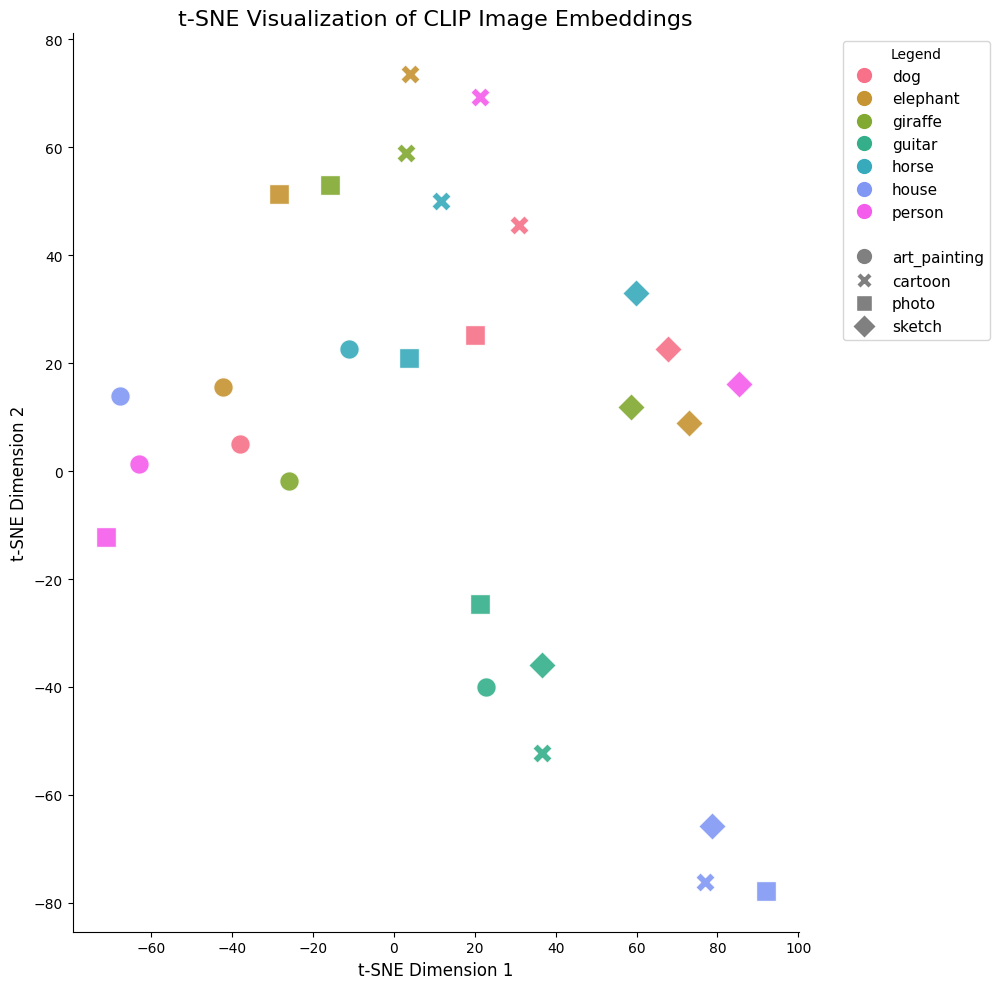

In [23]:
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
import seaborn as sns

# This code assumes you have already run the data assembly and have the following lists:
# - viz_images
# - viz_labels_class
# - viz_labels_domain
# It also assumes you have run the embedding extraction to get:
# - clip_embeddings

# --- 1. Run t-SNE ---
# Perplexity should be less than the number of samples (21 in this case). 
# A value of 15 is a good choice.
tsne = TSNE(n_components=2, perplexity=5, random_state=42, max_iter=1000)
tsne_results = tsne.fit_transform(clip_embeddings)

print("t-SNE computation complete. Result shape:", tsne_results.shape)

# --- 2. Prepare for Plotting (Dynamically) ---

# Automatically find all unique classes and assign a color to each.
unique_classes = sorted(list(set(viz_labels_class)))
colors = sns.color_palette("husl", len(unique_classes)) # Generate as many colors as needed
class_to_color = {cls: color for cls, color in zip(unique_classes, colors)}

# Automatically find all unique domains and assign a marker to each.
unique_domains = sorted(list(set(viz_labels_domain)))
# We provide a longer list of markers to handle more domains.
available_markers = ['o', 'X', 's', 'D', '^', 'P', '*', 'v'] 
markers_to_use = available_markers[:len(unique_domains)] # Select as many markers as needed
domain_to_marker = {dom: marker for dom, marker in zip(unique_domains, markers_to_use)}

print("\n--- Plotting Legend ---")
print("Class -> Color:", class_to_color.keys())
print("Domain -> Marker:", domain_to_marker)
print("-----------------------\n")


# --- 3. Create the Plot ---
plt.figure(figsize=(12, 10))
ax = plt.subplot(1, 1, 1)

for i in range(len(tsne_results)):
    ax.scatter(
        tsne_results[i, 0], 
        tsne_results[i, 1],
        color=class_to_color[viz_labels_class[i]],
        marker=domain_to_marker[viz_labels_domain[i]],
        s=200, # Increased size for better visibility
        alpha=0.9,
        edgecolors='w' # Add a white edge to markers to distinguish overlapping points
    )

plt.title("t-SNE Visualization of CLIP Image Embeddings", fontsize=16)
plt.xlabel("t-SNE Dimension 1", fontsize=12)
plt.ylabel("t-SNE Dimension 2", fontsize=12)
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

# --- 4. Create a clean legend ---
legend_handles = []
# Class legend (colors)
for cls, color in class_to_color.items():
    legend_handles.append(plt.Line2D([0], [0], marker='o', color='w', label=cls,
                                     markerfacecolor=color, markersize=12))
# Add a spacer in the legend
legend_handles.append(plt.Line2D([0], [0], marker='', color='w', label=''))

# Domain legend (markers)
for dom, marker in domain_to_marker.items():
    legend_handles.append(plt.Line2D([0], [0], marker=marker, color='w', label=dom,
                                     markerfacecolor='gray', markersize=12))

plt.legend(handles=legend_handles, bbox_to_anchor=(1.05, 1), loc='upper left', title="Legend", fontsize=11)
plt.tight_layout(rect=[0, 0, 0.85, 1]) # Adjust layout to make room for legend
plt.show()

<h3> Supervised Model: <h3>

In [10]:
import torch
import torch.nn as nn

# The standard ResNet-50 architecture ends with an Adaptive Average Pooling layer (`avgpool`)
# followed by a final fully connected layer (`fc`). We want the output of `avgpool`.
class ResNetFeatureExtractor(nn.Module):
    def __init__(self, original_model):
        super(ResNetFeatureExtractor, self).__init__()
        # Copy all layers from the original model except the final 'fc' layer
        self.features = nn.Sequential(*list(original_model.children())[:-1])
        
    def forward(self, x):
        x = self.features(x)
        # The output of the Sequential block is (batch_size, channels, 1, 1).
        # We flatten it to (batch_size, channels) to get a clean embedding vector.
        x = torch.flatten(x, 1)
        return x

if 'baseline_model' in locals() and baseline_model is not None:
    # Create an instance of our feature extractor
    resnet_extractor = ResNetFeatureExtractor(baseline_model).to(device)
    resnet_extractor.eval() # Ensure it's in evaluation mode
    print("ResNet-50 feature extractor created successfully.")

ResNet-50 feature extractor created successfully.


In [11]:
import torchvision.transforms as transforms
from tqdm import tqdm
import numpy as np


# We must use the correct ResNet transforms
transform_resnet = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

def get_resnet_embeddings(image_list, extractor_model, transform, device, batch_size=32):
    embeddings = []
    extractor_model.eval()
    
    with torch.no_grad():
        # Process in batches for efficiency
        for i in tqdm(range(0, len(image_list), batch_size), desc="Extracting ResNet Embeddings"):
            batch_images = image_list[i:i+batch_size]
            
            # Apply the transform to each image in the batch
            batch_tensors = torch.stack([transform(img) for img in batch_images]).to(device)
            
            # Get the features
            batch_features = extractor_model(batch_tensors)
            
            # Move to CPU, convert to numpy, and add to our list
            embeddings.append(batch_features.cpu().numpy())
            
    # Concatenate all batch results into a single numpy array
    return np.vstack(embeddings)

if resnet_extractor:
    # Use the same viz_images as before!
    resnet_embeddings = get_resnet_embeddings(viz_images, resnet_extractor, transform_resnet, device)
    print(f"\nExtracted ResNet embeddings. Shape: {resnet_embeddings.shape}")
    # The shape should be (num_images, 2048)

Extracting ResNet Embeddings: 100%|██████████| 1/1 [00:00<00:00,  2.79it/s]


Extracted ResNet embeddings. Shape: (28, 2048)


t-SNE computation for ResNet complete. Result shape: (28, 2)

--- Plotting Legend ---
Class -> Color: dict_keys(['dog', 'elephant', 'giraffe', 'guitar', 'horse', 'house', 'person'])
Domain -> Marker: {'art_painting': 'o', 'cartoon': 'X', 'photo': 's', 'sketch': 'D'}
-----------------------



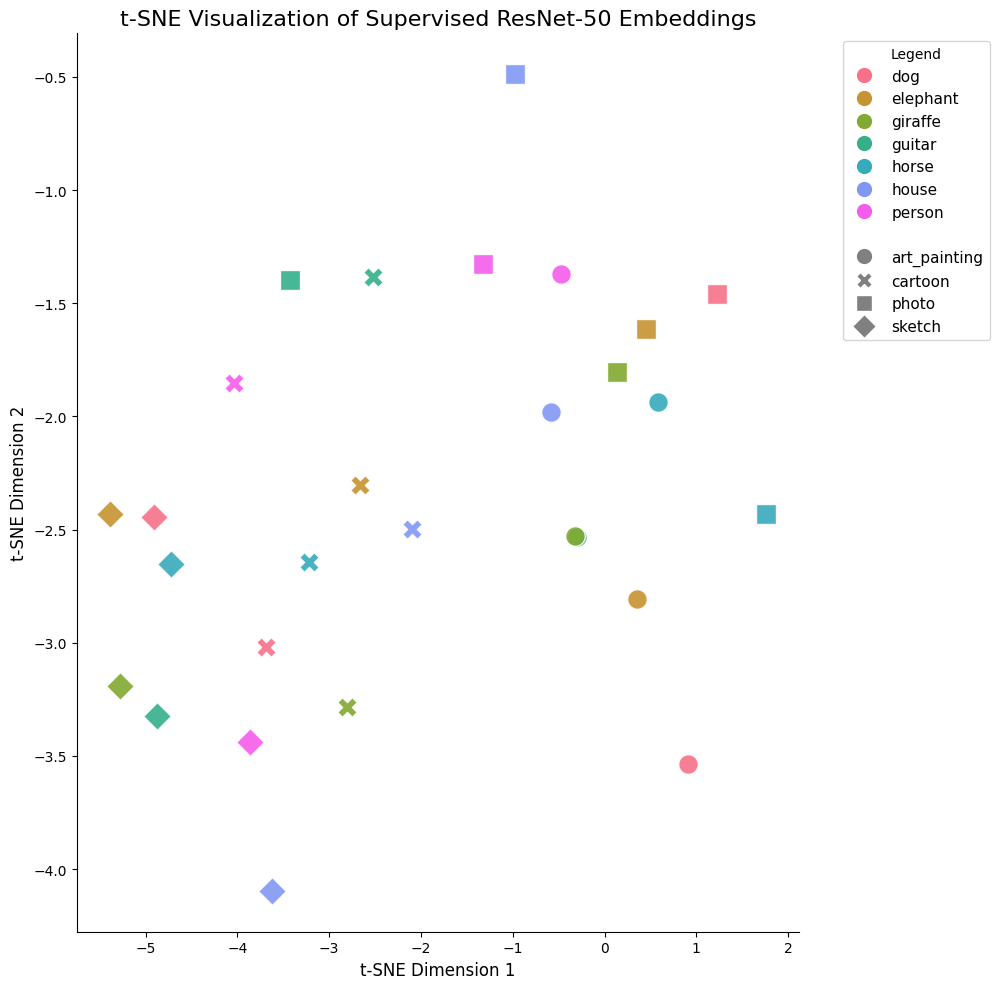

In [12]:
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
import seaborn as sns

# This code assumes you have already run the previous cells and have:
# - resnet_embeddings (from the feature extractor)
# - viz_labels_class (from the data assembly)
# - viz_labels_domain (from the data assembly)

# --- 1. Run t-SNE on the ResNet embeddings ---
# Using the same parameters as the CLIP plot for a fair comparison.
tsne_resnet = TSNE(n_components=2, perplexity=15, random_state=42, max_iter=1000)
tsne_results_resnet = tsne_resnet.fit_transform(resnet_embeddings)
print("t-SNE computation for ResNet complete. Result shape:", tsne_results_resnet.shape)

# --- 2. Prepare for Plotting (Dynamically) ---
# We re-create the mapping here to ensure this cell can be run independently if needed.

# Automatically find all unique classes and assign a color to each.
unique_classes = sorted(list(set(viz_labels_class)))
colors = sns.color_palette("husl", len(unique_classes))
class_to_color = {cls: color for cls, color in zip(unique_classes, colors)}

# Automatically find all unique domains and assign a marker to each.
unique_domains = sorted(list(set(viz_labels_domain)))
# Provide a longer list of markers to handle the 5 domains.
available_markers = ['o', 'X', 's', 'D', '^', 'P', '*', 'v'] 
markers_to_use = available_markers[:len(unique_domains)]
domain_to_marker = {dom: marker for dom, marker in zip(unique_domains, markers_to_use)}

print("\n--- Plotting Legend ---")
print("Class -> Color:", class_to_color.keys())
print("Domain -> Marker:", domain_to_marker)
print("-----------------------\n")


# --- 3. Create the Plot ---
plt.figure(figsize=(12, 10))
ax = plt.subplot(1, 1, 1)

for i in range(len(tsne_results_resnet)):
    ax.scatter(
        tsne_results_resnet[i, 0], 
        tsne_results_resnet[i, 1],
        color=class_to_color[viz_labels_class[i]],
        marker=domain_to_marker[viz_labels_domain[i]],
        s=200, # Increased size for better visibility
        alpha=0.9,
        edgecolors='w' # Add a white edge to markers to distinguish overlapping points
    )

plt.title("t-SNE Visualization of Supervised ResNet-50 Embeddings", fontsize=16)
plt.xlabel("t-SNE Dimension 1", fontsize=12)
plt.ylabel("t-SNE Dimension 2", fontsize=12)
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

# --- 4. Create a clean legend ---
legend_handles = []
# Class legend (colors)
for cls, color in class_to_color.items():
    legend_handles.append(plt.Line2D([0], [0], marker='o', color='w', label=cls,
                                     markerfacecolor=color, markersize=12))
# Add a spacer in the legend
legend_handles.append(plt.Line2D([0], [0], marker='', color='w', label=''))

# Domain legend (markers)
for dom, marker in domain_to_marker.items():
    legend_handles.append(plt.Line2D([0], [0], marker=marker, color='w', label=dom,
                                     markerfacecolor='gray', markersize=12))

plt.legend(handles=legend_handles, bbox_to_anchor=(1.05, 1), loc='upper left', title="Legend", fontsize=11)
plt.tight_layout(rect=[0, 0, 0.85, 1]) # Adjust layout to make room for legend
plt.show()

<h2> Part 4: Shape vs. Texture Bias Test <h2>

<h3> CLIP: <h3>

In [13]:
# --- Define Image Sources ---
image_sources = {
    "Normal Cat": {
        "type": "url",
        "source": "https://raw.githubusercontent.com/rgeirhos/texture-vs-shape/master/stimuli/visualisation-stimuli/cat7_original.png"
    },
    "Cue-Conflict (Paper)": {
        "type": "url",
        "source": "https://raw.githubusercontent.com/rgeirhos/texture-vs-shape/master/stimuli/visualisation-stimuli/cat7-elephant1_nomask.png"
    },
    "Cue-Conflict (AI Cat-Shape)": {
        "type": "local",
        "source": "C:/Users/Haseeb/OneDrive - Higher Education Commission/ATML (CS6304)/PA1/ATML_PA1/cat_elephant_texture.png" 
    },
    "Cue-Conflict (AI Elephant-Shape)": {
        "type": "local",
        "source": "C:/Users/Haseeb/OneDrive - Higher Education Commission/ATML (CS6304)/PA1/ATML_PA1/elephant_cat_texture.png"
    }
}

# --- Define Prompt Styles ---
prompt_styles = {
    "Simple": ["a cat", "an elephant"],
    "Photo": ["a photo of a cat", "a photo of an elephant"],
    "Descriptive": ["an image showing a cat", "an image showing an elephant"]
}

In [30]:
images = {}
print("--- Loading Images ---")
for name, data in image_sources.items():
    try:
        if data["type"] == "url":
            image = Image.open(requests.get(data["source"], stream=True).raw).convert("RGB")
        elif data["type"] == "local":
            image = Image.open(data["source"]).convert("RGB")
        images[name] = image
        print(f"Successfully loaded: {name}")
    except Exception as e:
        images[name] = None
        print(f"FAILED to load: {name}. Reason: {e}")
        print("Please check the path/URL and try again.")
print("-" * 25)

--- Loading Images ---
Successfully loaded: Normal Cat
Successfully loaded: Cue-Conflict (Paper)
Successfully loaded: Cue-Conflict (AI Cat-Shape)
Successfully loaded: Cue-Conflict (AI Elephant-Shape)
-------------------------


In [31]:
# Re-using our robust helper function
def run_bias_test(image, query_list, model, processor, device):
    """A helper function to run our test on any image."""
    if image is None: return None
    inputs = processor(text=query_list, images=image, return_tensors="pt", padding=True).to(device)
    with torch.no_grad():
        outputs = model(**inputs)
    probs = outputs.logits_per_image.softmax(dim=1).cpu().numpy()[0]
    return {query: prob for query, prob in zip(query_list, probs)}


--- Running Full Bias Test Suite ---

==================== Testing Image: Normal Cat ====================

--- Prompt Style: Simple ---
  'a cat': 0.9988
  'an elephant': 0.0012
  --> Model Decision: SHAPE

--- Prompt Style: Photo ---
  'a photo of a cat': 0.9996
  'a photo of an elephant': 0.0004
  --> Model Decision: SHAPE

--- Prompt Style: Descriptive ---
  'an image showing a cat': 0.9999
  'an image showing an elephant': 0.0001
  --> Model Decision: SHAPE

==================== Testing Image: Cue-Conflict (Paper) ====================

--- Prompt Style: Simple ---
  'a cat': 0.2022
  'an elephant': 0.7978
  --> Model Decision: TEXTURE

--- Prompt Style: Photo ---
  'a photo of a cat': 0.2196
  'a photo of an elephant': 0.7804
  --> Model Decision: TEXTURE

--- Prompt Style: Descriptive ---
  'an image showing a cat': 0.4673
  'an image showing an elephant': 0.5327
  --> Model Decision: TEXTURE

==================== Testing Image: Cue-Conflict (AI Cat-Shape) ====================

-

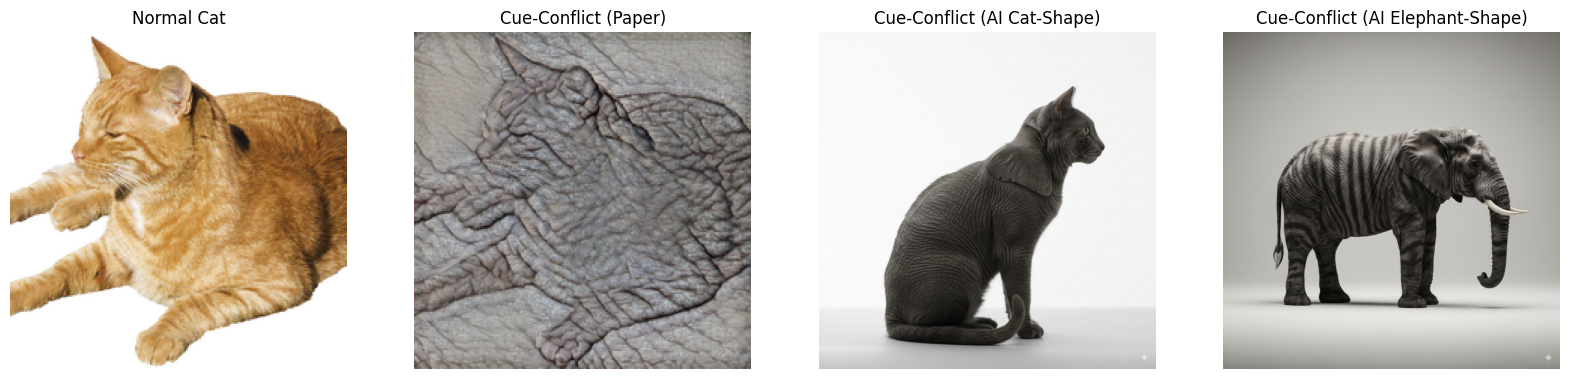

In [32]:
print("\n--- Running Full Bias Test Suite ---")

for image_name, image_obj in images.items():
    if image_obj is None:
        continue # Skip if image failed to load
    
    print(f"\n==================== Testing Image: {image_name} ====================")
    
    for style_name, queries in prompt_styles.items():
        results = run_bias_test(image_obj, queries, model, processor, device)
        
        prob_cat = results[queries[0]]
        prob_elephant = results[queries[1]]
        
        # Determine the bias based on the image type
        if "Elephant-Shape" in image_name: # For the elephant with cat texture
            decision = "SHAPE" if prob_elephant > prob_cat else "TEXTURE"
        else: # For all other images (normal cat and cat-shape conflicts)
            decision = "SHAPE" if prob_cat > prob_elephant else "TEXTURE"
            
        print(f"\n--- Prompt Style: {style_name} ---")
        print(f"  '{queries[0]}': {prob_cat:.4f}")
        print(f"  '{queries[1]}': {prob_elephant:.4f}")
        print(f"  --> Model Decision: {decision}")

print("\n" + "=" * 55)
print("Test suite complete.")

# --- Optional: Display the images at the end ---
fig, axes = plt.subplots(1, len(images), figsize=(20, 5))
for i, (name, img) in enumerate(images.items()):
    if img:
        axes[i].imshow(img)
        axes[i].set_title(name)
        axes[i].axis('off')
plt.show()

<h2> Part 5: Robustness Analysis <h2>

Base image (Normal Cat) loaded successfully.
Created 4 corrupted versions of the image.


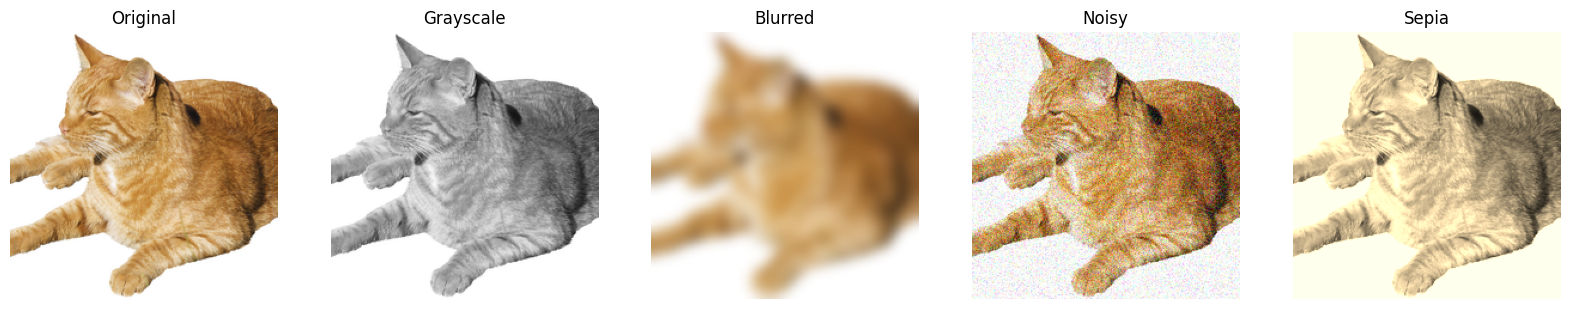

In [33]:
import requests
from PIL import Image, ImageFilter, ImageOps
import numpy as np
import matplotlib.pyplot as plt

# --- 1. Load the Base Image ---
base_image_url = "https://raw.githubusercontent.com/rgeirhos/texture-vs-shape/master/stimuli/visualisation-stimuli/cat7_original.png"
try:
    base_image = Image.open(requests.get(base_image_url, stream=True).raw).convert("RGB")
    print("Base image (Normal Cat) loaded successfully.")
except Exception as e:
    base_image = None
    print(f"Failed to load base image: {e}")

# --- 2. Create a dictionary to hold all image versions ---
if base_image:
    image_variants = {"Original": base_image}

    # --- Corruption 1: Grayscale ---
    image_variants["Grayscale"] = ImageOps.grayscale(base_image).convert("RGB")

    # --- Corruption 2: Gaussian Blur ---
    # The radius determines the strength of the blur.
    image_variants["Blurred"] = base_image.filter(ImageFilter.GaussianBlur(radius=5))

    # --- Corruption 3: Adding Gaussian Noise ---
    img_array = np.array(base_image)
    noise = np.random.normal(0, 25, img_array.shape) # mean=0, std_dev=25
    noisy_img_array = np.clip(img_array + noise, 0, 255).astype(np.uint8)
    image_variants["Noisy"] = Image.fromarray(noisy_img_array)

    # --- Corruption 4: Sepia Tone (Strong Color Shift) ---
    def to_sepia(image):
        img = image.copy()
        pixels = img.load()
        width, height = img.size
        for y in range(height):
            for x in range(width):
                r, g, b = img.getpixel((x, y))
                tr = int(0.393 * r + 0.769 * g + 0.189 * b)
                tg = int(0.349 * r + 0.686 * g + 0.168 * b)
                tb = int(0.272 * r + 0.534 * g + 0.131 * b)
                pixels[x, y] = (min(tr, 255), min(tg, 255), min(tb, 255))
        return img
    image_variants["Sepia"] = to_sepia(base_image)

    print(f"Created {len(image_variants)-1} corrupted versions of the image.")

    # --- Display the variants to see what they look like ---
    fig, axes = plt.subplots(1, len(image_variants), figsize=(20, 4))
    for i, (name, img) in enumerate(image_variants.items()):
        axes[i].imshow(img)
        axes[i].set_title(name)
        axes[i].axis('off')
    plt.show()

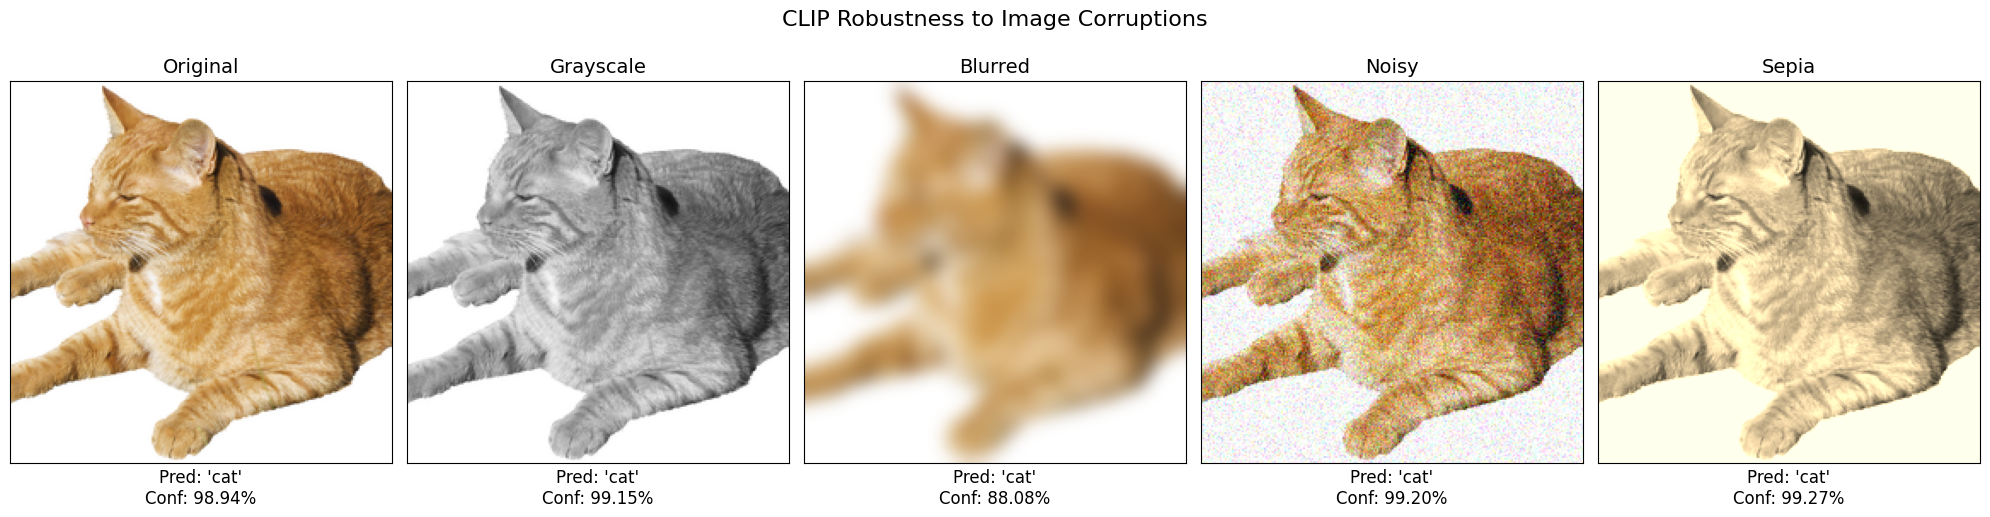

In [34]:
import torch

if 'image_variants' in locals() and image_variants:
    # --- 1. Define Queries ---
    # We use two distinct classes to get a clear probability score.
    robustness_queries = ["a photo of a cat", "a photo of a dog"]
    
    # --- 2. Loop, Classify, and Store Results ---
    results = {}
    for name, img in image_variants.items():
        # Use our reliable testing function
        probs = run_bias_test(img, robustness_queries, model, processor, device)
        
        # Determine top prediction and its confidence
        if probs[robustness_queries[0]] > probs[robustness_queries[1]]:
            top_prediction = "cat"
            confidence = probs[robustness_queries[0]]
        else:
            top_prediction = "dog"
            confidence = probs[robustness_queries[1]]
            
        results[name] = f"Pred: '{top_prediction}'\nConf: {confidence:.2%}"

    # --- 3. Visualize the Final Report ---
    fig, axes = plt.subplots(1, len(image_variants), figsize=(20, 5))
    fig.suptitle("CLIP Robustness to Image Corruptions", fontsize=16)
    
    for i, name in enumerate(image_variants.keys()):
        img = image_variants[name]
        annotation = results[name]
        
        axes[i].imshow(img)
        axes[i].set_title(name, fontsize=14)
        axes[i].set_xlabel(annotation, fontsize=12) # Use xlabel for the annotation
        axes[i].set_xticks([]) # Remove ticks
        axes[i].set_yticks([])

    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    plt.show()